In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
def sin_trajectory(t):
    return math.sin(t)

def spiral_trajectory(t):
    return torch.tensor([t * math.cos(t), t * math.sin(t)])

In [3]:
def plot_trajectory(trajectory, estimated_trajectory, 
                    generator_function, estimation_function,
                    title):
    plt.figure(figsize=(8, 4))
    plt.plot(trajectory[:, 0].numpy(), trajectory[:, 1].numpy(), label=f'{generator_function}(t)')
    plt.plot(estimated_trajectory[:, 0].numpy(), estimated_trajectory[:, 1].numpy(), label=f'{estimation_function}(t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
PERIOD = 4
times = torch.linspace(0, PERIOD * 2 * math.pi, steps=100)
#values = torch.tensor([sin_trajectory(t.item()) for t in times])
#trajectory = torch.stack([times, values], dim=1)
trajectory = torch.stack([spiral_trajectory(t.item()) for t in times])
trajectory = trajectory.flip(0)

In [5]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim + 1] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)

		for m in self.mlp.modules():
			if isinstance(m, nn.Linear):
				nn.init.normal_(m.weight, mean=0, std=0.1)
				nn.init.constant_(m.bias, val=0)
	
	def forward(self, t, x):
		state = torch.cat([t.unsqueeze(0), x], dim=0)
		x_dot = self.mlp(state)
		return x_dot

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
#ode = ODE(2, (256 for _ in range(3))).to(device)
ode = ODE(2, (50 for _ in range(1))).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-3, weight_decay=0)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = torch.mean(torch.abs(trajectory - estimated_trajectory))#F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    #scheduler.step()

Epoch 1, Loss: 10.41218090057373
Epoch 2, Loss: 10.024331092834473
Epoch 3, Loss: 9.679899215698242
Epoch 4, Loss: 9.463217735290527
Epoch 5, Loss: 9.363234519958496
Epoch 6, Loss: 9.323705673217773
Epoch 7, Loss: 9.310651779174805
Epoch 8, Loss: 9.294918060302734
Epoch 9, Loss: 9.265103340148926
Epoch 10, Loss: 9.230809211730957
Epoch 11, Loss: 9.193727493286133
Epoch 12, Loss: 9.15958309173584
Epoch 13, Loss: 9.130668640136719
Epoch 14, Loss: 9.107356071472168
Epoch 15, Loss: 9.087652206420898
Epoch 16, Loss: 9.06781005859375
Epoch 17, Loss: 9.045083045959473
Epoch 18, Loss: 9.018651008605957
Epoch 19, Loss: 8.990265846252441
Epoch 20, Loss: 8.96126651763916
Epoch 21, Loss: 8.931795120239258
Epoch 22, Loss: 8.90327262878418
Epoch 23, Loss: 8.875520706176758
Epoch 24, Loss: 8.848536491394043
Epoch 25, Loss: 8.825369834899902
Epoch 26, Loss: 8.80640697479248
Epoch 27, Loss: 8.78891658782959
Epoch 28, Loss: 8.774195671081543
Epoch 29, Loss: 8.759647369384766
Epoch 30, Loss: 8.7462940216

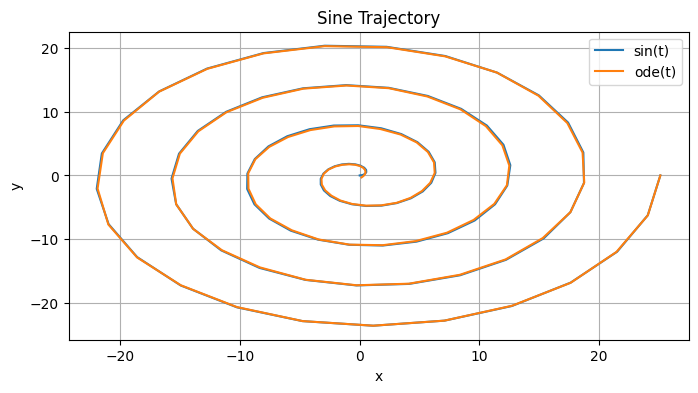

In [8]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')

In [24]:
class FourierFeatureODE(nn.Module):
    def __init__(self, input_dim, hidden_dims, fourier_scale=10.0, num_fourier_features=10):
        super(FourierFeatureODE, self).__init__()
        
        self.num_fourier_features = num_fourier_features
        
        fourier_expanded_dim = input_dim + 2 * num_fourier_features
        #dim_list = [fourier_expanded_dim + 1] + list(hidden_dims) + [input_dim]
        dim_list = [fourier_expanded_dim] + list(hidden_dims) + [input_dim]
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i < len(dim_list) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

        # for m in self.mlp.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, mean=0, std=0.1)
        #         nn.init.constant_(m.bias, val=0)
    
    def compute_positional_fourier_features(self, x):
        encodings = [x]
        for i in range(self.num_fourier_features // 2):
            freq = 2.0 ** i
            sin_features = torch.sin(freq * x)
            cos_features = torch.cos(freq * x)
            encodings.append(sin_features)
            encodings.append(cos_features)
        return torch.cat(encodings, dim=-1)

    def forward(self, t, x):
        x_fourier = self.compute_positional_fourier_features(x)
        #state = torch.cat([t.unsqueeze(0), x_fourier], dim=0)
        x_dot = self.mlp(x_fourier)
        return x_dot

In [32]:
ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=4).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-3, weight_decay=0)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

#EPOCHS = 10000
EPOCHS = 5000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = torch.mean(torch.abs(trajectory - estimated_trajectory))#F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    #scheduler.step()

Epoch 1, Loss: 15.45872688293457
Epoch 2, Loss: 10.922499656677246
Epoch 3, Loss: 8.91031551361084
Epoch 4, Loss: 8.455241203308105
Epoch 5, Loss: 8.40460205078125
Epoch 6, Loss: 8.326437950134277
Epoch 7, Loss: 8.227469444274902
Epoch 8, Loss: 8.145626068115234
Epoch 9, Loss: 8.061432838439941
Epoch 10, Loss: 7.991450786590576
Epoch 11, Loss: 7.934167385101318
Epoch 12, Loss: 7.882331371307373
Epoch 13, Loss: 7.847743511199951
Epoch 14, Loss: 7.818572998046875
Epoch 15, Loss: 7.7932586669921875
Epoch 16, Loss: 7.768489837646484
Epoch 17, Loss: 7.744064807891846
Epoch 18, Loss: 7.72024393081665
Epoch 19, Loss: 7.703947067260742
Epoch 20, Loss: 7.6882853507995605
Epoch 21, Loss: 7.673676490783691
Epoch 22, Loss: 7.659969329833984
Epoch 23, Loss: 7.648850917816162
Epoch 24, Loss: 7.637603759765625
Epoch 25, Loss: 7.629462718963623
Epoch 26, Loss: 7.620964050292969
Epoch 27, Loss: 7.615538120269775
Epoch 28, Loss: 7.61164665222168
Epoch 29, Loss: 7.607494831085205
Epoch 30, Loss: 7.602131

KeyboardInterrupt: 

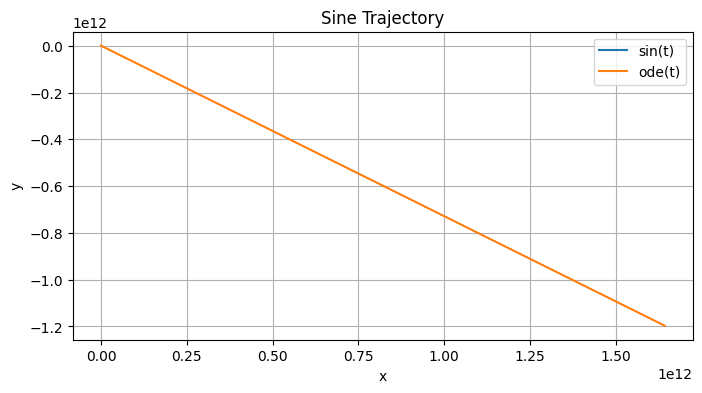

In [26]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')